In [525]:
! pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz==1.4.1
! pip install graphviz fastai pandas scikit-learn dtreeviz IPython opendatasets numpy matplotlib seaborn xgboost lightgbm --upgrade --quiet


In [526]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
from fastai.imports import *
import pandas as pd
import numpy as np
import opendatasets as od
import os
pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [527]:
creds = '{"username":"alishaikhhusain","key":"8e997994b86665a851cae21c41599ee8"}'

In [528]:
# downloading the dataset using the opendatasets library to download the dataset directly from kaggle & to use 
# it inside the jupyter notebook
od.download('https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction/data')

Skipping, found downloaded files in "./flight-price-prediction" (use force=True to force download)


In [529]:
os.listdir('flight-price-prediction')

['economy.csv', 'Clean_Dataset.csv', 'business.csv']

In [530]:
df = pd.read_csv('flight-price-prediction/Clean_Dataset.csv',low_memory=False)

In [531]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [532]:
# taking the log of the prices will fix how the prices are distributed
# as you can see the prices are now centered and the graph show a good distribution
dep_var = 'price'
df[dep_var] = np.log(df[dep_var])

<Axes: >

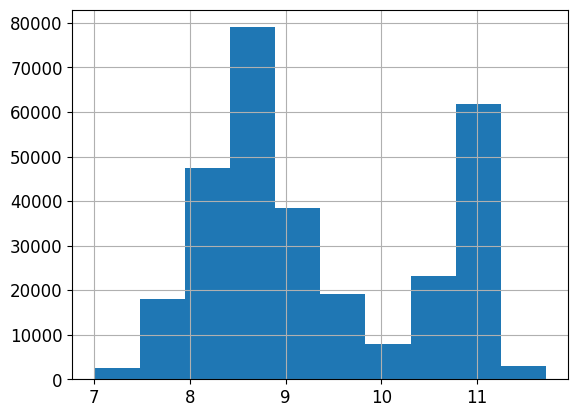

In [533]:
df[dep_var].hist()

### Taking the last 15 records for the Test Set

In [534]:
train_validation_sets = df[:-15]
test_df = df[-15:]

In [535]:
# from sklearn.model_selection import train_test_split

# # lets make a training, validation and test splits
# train_validation_sets, test_df = train_test_split(
#     df, test_size=0.2, random_state=42)

# train_df , val_df = train_test_split(
#     train_validation_sets, test_size=0.25, random_state=42)

### Splitting Train_Validation sets into 70% , 30% 

In [536]:
df = train_validation_sets
splits = RandomSplitter(valid_pct=0.3,seed=42)(df)

In [537]:
len(splits[0]),len(splits[1]),len(df)

(210097, 90041, 300138)

### Processing the data 

In [538]:
procs = [Categorify, FillMissing]

In [539]:
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)

In [540]:
to = TabularPandas(df, procs,cat,cont,y_names=dep_var,splits=splits)

In [541]:
# fastai provides this save method that uses the Python pickle system that saves 
# nearly any Python Object, very cool

save_pickle('./to.pkl',to)

#### Creating the Decision Tree

In [542]:
to = load_pickle('./to.pkl')

# Y

In [543]:
# extract the pandas dataframe inorder to work with the machine learning and deep learning models 
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [544]:
y

184131     8.195609
91816      8.311644
171720     9.629313
28597      9.124891
96078      8.551981
            ...    
169902     7.482119
138219     8.731498
48950      8.621013
173444     7.780303
265867    11.079539
Name: price, Length: 210097, dtype: float32

In [545]:
from sklearn.tree import DecisionTreeRegressor

In [546]:
m = DecisionTreeRegressor()
m.fit(xs,y)

DecisionTreeRegressor()

In [547]:
import math
def r_mse(pred, y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [548]:
m_rmse(m,xs,y), m_rmse(m,valid_xs,valid_y)

(0.006957, 0.155991)

In [549]:
m.get_n_leaves(), len(xs)

(72830, 210097)

In [550]:
m = DecisionTreeRegressor(min_samples_leaf=25).fit(xs, y)
m_rmse(m, xs, y), m_rmse(m, to.valid.xs, to.valid.y)

(0.150143, 0.161306)

In [551]:
m.get_n_leaves()

5944

### Create a RandomForest

In [552]:
from sklearn.ensemble import RandomForestRegressor

# we will make a function to traverse and try different parameters for the RandomForest
# n_estimators = 40 --> number of trees, if you have time and enough sleep increase this number
# max_samples = 200,000 rows , but we have 192,000 train datapoints , let's see if anything here breaks 
# max_features = 0.5 --> randomly take half the columns to train a single tree
# min_samples_leaf= 5 --> the final leaf node shall contain at least 5 rows of data (5 airplane tickets)
# n_jobs = -1 --> tell sklearn to use all of our CPU brain power to run this in parallel
# oob_score = True --> explain this later

# things to test here, increase the # of trees, use sklearn default max_feature, use the min_samples_leaf default of sklearn
# then report your findings
def rf(xs, y, n_estimators=50, max_samples=160_000, max_features=0.5, min_samples_leaf=4, **kwargs):
    return RandomForestRegressor(n_estimators=n_estimators, max_samples=max_samples, 
                                 max_features=max_features, min_samples_leaf=min_samples_leaf,
                                 oob_score=True , n_jobs=-1).fit(xs,y)

In [553]:
m = rf(xs,y)

In [554]:
m_rmse(m,xs,y), m_rmse(m,valid_xs,valid_y)

(0.108472, 0.130957)

### Feature Importances 

In [555]:
def rf_feature_importance(m,df):
  return pd.DataFrame(
    {'cols':df.columns, 'imp':m.feature_importances_}
  ).sort_values('imp',ascending=False)
  

In [556]:
fi = rf_feature_importance(m,xs)
fi

,cols,imp
7,class,0.763426
9,days_left,0.064627
1,flight,0.060974
8,duration,0.039179
0,airline,0.036718
4,stops,0.015439
6,destination_city,0.008066
2,source_city,0.006753
3,departure_time,0.002432
5,arrival_time,0.002386


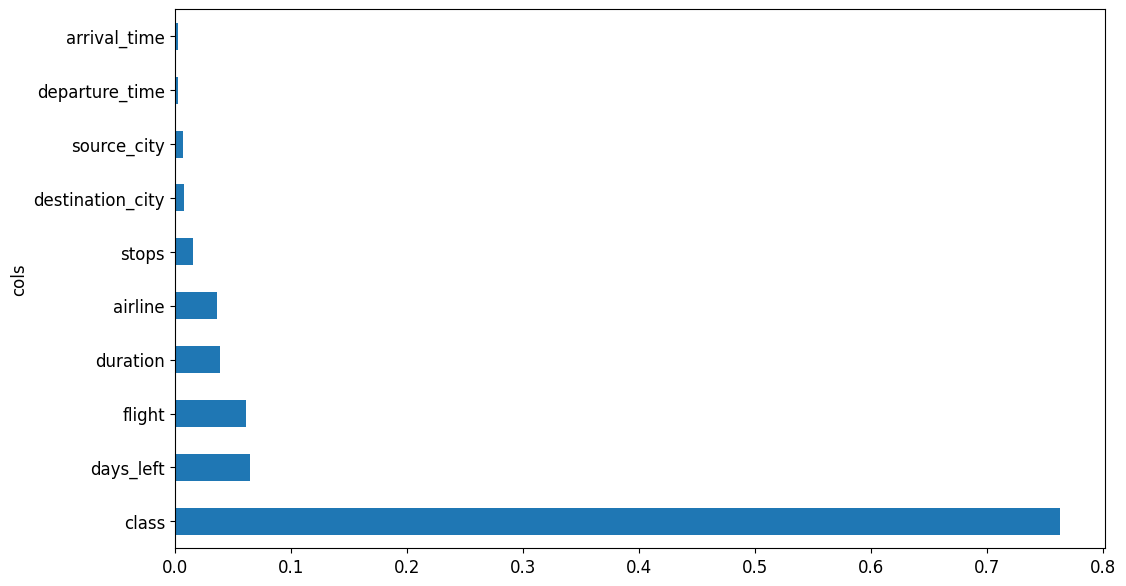

In [557]:
def plot_fi(fi): 
  return fi.plot('cols','imp','barh', figsize=(12,7),legend=False)

plot_fi(fi);

In [558]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep),len(fi.cols)

(8, 10)

In [559]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [560]:
m = rf(xs_imp,y)

In [561]:
m_rmse(m,xs_imp,y), m_rmse(m,valid_xs_imp,valid_y)


(0.1124, 0.13492)

In [562]:
xs_final = xs_imp
valid_xs_final = valid_xs_imp

In [563]:
save_pickle('./xs_final.pkl',xs_final)
save_pickle('./valid_xs_final.pkl',valid_xs_final)

## Final chosen Features

In [564]:
xs = load_pickle('./xs_final.pkl')
val_xs = load_pickle('./valid_xs_final.pkl')

In [565]:
m = rf(xs, y)
m_rmse(m, xs, y), m_rmse(m, val_xs, valid_y)

(0.1128, 0.135341)

### USING NEURAL NETWORKS

In [566]:
# copying the main training and validation dataset 
# we will deal with in terms of cleaning the dataset a bit differently 
# because neural networks are sensitive to outliers, unlike decision trees and random forest
df_nn = train_validation_sets.copy()

In [567]:
df_nn_final = df_nn[xs.columns.tolist() +[dep_var]].copy()

In [568]:
df_nn_final['days_left'] = df_nn_final['days_left'].astype(float)

In [569]:
df_nn_final

,class,days_left,flight,duration,...,stops,destination_city,source_city,price
0,Economy,1.0,SG-8709,2.17,...,zero,Mumbai,Delhi,8.691651
1,Economy,1.0,SG-8157,2.33,...,zero,Mumbai,Delhi,8.691651
2,Economy,1.0,I5-764,2.17,...,zero,Mumbai,Delhi,8.692154
3,Economy,1.0,UK-995,2.25,...,zero,Mumbai,Delhi,8.691986
4,Economy,1.0,UK-963,2.33,...,zero,Mumbai,Delhi,8.691986
...,...,...,...,...,...,...,...,...,...
300133,Business,49.0,UK-834,19.17,...,one,Hyderabad,Chennai,10.848502
300134,Business,49.0,UK-838,19.92,...,one,Hyderabad,Chennai,10.848502
300135,Business,49.0,UK-838,22.75,...,one,Hyderabad,Chennai,10.848502
300136,Business,49.0,UK-834,23.58,...,one,Hyderabad,Chennai,10.848502


In [570]:
# there is a problem with the days_left parameter
# i think this may cause problems, fix it later ... 
cont_nn, cat_nn = cont_cat_split(df_nn_final, max_card=9000,dep_var=dep_var)

In [571]:
df_nn_final[cat_nn].nunique()

class                  2
flight              1561
airline                6
stops                  3
destination_city       6
source_city            6
dtype: int64

In [572]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn,
                      cont_nn, splits=splits, y_names=dep_var)

In [573]:
dls = to_nn.dataloaders(1024) # do not require much GPU ram

In [574]:
y = to_nn.train.y

In [575]:
y.min(),y.max()

(7.007601, 11.672549)

In [576]:
learn = tabular_learner(dls, y_range=(7,12), layers=[100,50],
                        n_out=1, loss_func=F.mse_loss)

In [577]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.063725,0.045016,00:03
1,0.036229,0.037017,00:03
2,0.030994,0.031473,00:03
3,0.026543,0.026725,00:03
4,0.023764,0.025006,00:03


In [578]:
preds,targets = learn.get_preds()
r_mse(preds, targets) # results on the validation set

0.158132

# Testing the neural network on a full dataset

In [579]:
from sklearn.model_selection import train_test_split

train_df , val_df = train_test_split(
    train_validation_sets, test_size=0.25, random_state=42)

In [580]:
train_df = train_df[xs.columns.tolist() + [dep_var]]
val_df = val_df[xs.columns.tolist() + [dep_var]]
test_df = test_df[xs.columns.tolist() + [dep_var]]

val_y = val_df['price']
train_y = train_df[dep_var]
test_targets = test_df[dep_var]

In [581]:
dl = learn.dls.test_dl(train_df)
dl_val = learn.dls.test_dl(val_df)
dl_test = learn.dls.test_dl(test_df)

In [582]:
preds, _ = learn.get_preds(dl=dl)
preds_val, _ = learn.get_preds(dl=dl_val)
preds_test, _ = learn.get_preds(dl=dl_test)

In [583]:
r_mse(to_np(preds.squeeze()),train_y) , r_mse(to_np(preds_val.squeeze()),val_y) 

(0.150496, 0.14987)

In [584]:
# test results - this test set really shows how good the model is doing
r_mse(to_np(preds_test.squeeze()),test_targets) 

0.249508

### using XGBoost 

In [585]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold

In [586]:

from sklearn.model_selection import train_test_split

train_df , val_df = train_test_split(
    train_validation_sets, test_size=0.25, random_state=42)

# Load the TabularPandas object
to = load_pickle('./to.pkl')

test_df = df[-15:]
test_targets = test_df[dep_var]

# using the "tabularPandas" datacleaning to automatically apply changes to the following dataset
dl_test = to.dataloaders().test_dl(test_df)


In [587]:
# extract the xs(independent variables) from the dl_test dataloader
# which contains the test df preprocessed and ready to use
test_df = dl_test.train.xs
test_targets= dl_test.train.y

# make sure that you only get the final columns after "feature importance"
test_df = test_df[xs.columns.to_list()] 

In [588]:
# extract the pandas dataframe inorder to work with the machine learning and deep learning models 
y = to.train.y
valid_y = to.valid.y

In [589]:
xs = load_pickle('./xs_final.pkl')
val_xs = load_pickle('./valid_xs_final.pkl')

In [590]:
# making and fitting the xgboost models in a function
def xgboost(xs, y, **params):
    # using the GPU - for better training
    params['device'] = 'cuda'    
    # make a single model
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(xs, y)

    return model

In [591]:
def rf(xs, y, n_estimators=50, max_samples=140_000, max_features=0.5, min_samples_leaf=4, **kwargs):
    return RandomForestRegressor(n_estimators=n_estimators, max_samples=max_samples, 
                                 max_features=max_features, min_samples_leaf=min_samples_leaf,
                                 oob_score=True , n_jobs=-1).fit(xs,y)

In [592]:
m_xgb = xgboost(xs,y,learning_rate=0.3, n_estimators=700,
                  max_depth=10, subsample=0.9, colsample_bytree=0.7)

m_rf = rf(xs,y)

In [593]:
preds_xgb= m_xgb.predict(val_xs)
preds_rf = m_rf.predict(val_xs)

r_mse(preds_xgb,valid_y), r_mse(preds_rf,valid_y)

(0.121787, 0.136377)

### "THE TESTING SET"

In [594]:
preds_xgb= m_xgb.predict(test_df)
preds_rf = m_rf.predict(test_df)

r_mse(preds_xgb,test_targets), r_mse(preds_rf,test_targets) 

(0.040417, 0.067824)

very promising results for both bagging and boosting techniques

In [595]:
# making a nn to feed it inside the kfold function
# remember we are dealing with the 'whole dataset' to train and test all the models and see the 'rmsle'

# return the deeplearning model
def nn():
    learn = tabular_learner(dls, y_range=(7, 12), layers=[100, 50],
                            n_out=1, loss_func=F.mse_loss)
    learn.fit_one_cycle(5, 1e-2)
    return learn


# return the training predictions
def nn_predict_train(learn, X_train):
    X_train = X_train[xs.columns.tolist() + [dep_var]]
    dl = learn.dls.test_dl(X_train)
    preds, _ = learn.get_preds(dl=dl)
    return to_np(preds.squeeze())


# return the validation predictions
def nn_predict_val(learn, val_xs):
    val_xs = val_xs[xs.columns.tolist() + [dep_var]]
    dl_val = learn.dls.test_dl(val_xs)
    preds, _ = learn.get_preds(dl=dl_val)
    return to_np(preds.squeeze())

 
#### now setting up the data for xgboost and rf
 

In [596]:

def data_for_trees(X_train, val_xs):
    # Load the TabularPandas object
    to = load_pickle('./to.pkl')
    xs = load_pickle('./xs_final.pkl')

    # preprocess the data using the magical method test_dl()
    dl_train = to.dataloaders().test_dl(X_train)
    dl_val = to.dataloaders().test_dl(val_xs)

    train_df = dl_train.train.xs
    test_targets = dl_train.train.y  # remember there is no train targets here

    val_df = dl_val.train.xs
    val_targets = dl_val.train.y  # remember there is no train targets here
    

    # make sure that you only get the final columns after "feature importance"
    train_df = train_df[xs.columns.to_list()]
    val_df = val_df[xs.columns.tolist()]
    
    return train_df, val_df

# KFOLD ON THE WHOLE DATASET

In [597]:
def train_and_evaluate(X_train, train_targets, val_xs, val_targets, **params):
    
    train_df, val_df = data_for_trees(X_train, val_xs)

    xgb = xgboost(train_df, train_targets, learning_rate=0.3, n_estimators=700,
                  max_depth=10, subsample=0.9, colsample_bytree=0.7)  # first model created and trained

    rf_model = rf(train_df, train_targets, max_samples=X_train.shape[0])

    # add here the neural network
    learn = nn()
    

    # training rmse
    xgb_preds_train = xgb.predict(train_df)
    rf_preds_train = rf_model.predict(train_df)
    nn_preds_train =nn_predict_train(learn,X_train)
    
    # nn_preds_train,_ = learn.get_preds(dl=dl)
    combined_preds_train = [xgb_preds_train, rf_preds_train,nn_preds_train]

    preds_train = np.stack(combined_preds_train).mean(0)
    ensembled_train_rmse = r_mse(preds_train, train_targets)



    # validation rmse
    xgb_preds_val = xgb.predict(val_df)
    rf_preds_val = rf_model.predict(val_df)
    nn_preds_val = nn_predict_val(learn,val_xs)
    
    combined_preds_val = [rf_preds_val, xgb_preds_val,nn_preds_val]
    preds_val = np.stack(combined_preds_val).mean(0)
    ensembled_validation_rmse = r_mse(preds_val, val_targets)
    
    
    # printing results
    # print(f'Validation rmse: {ensembled_validation_rmse} || Training rmse: {ensembled_train_rmse} ')

    return ensembled_validation_rmse, ensembled_train_rmse, xgb, rf_model,learn

In [598]:
df = pd.read_csv('flight-price-prediction/Clean_Dataset.csv',low_memory=False)
df.drop(columns=['Unnamed: 0'], inplace=True)

dep_var = 'price'
df[dep_var] = np.log(df[dep_var]) # 300153

train_validation_sets = df[:-15] # 300138 rows
test_df = df[-15:] # 15 rows

df_y = df[dep_var]

In [599]:
df

,airline,flight,source_city,departure_time,...,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,...,Economy,2.17,1,8.691651
1,SpiceJet,SG-8157,Delhi,Early_Morning,...,Economy,2.33,1,8.691651
2,AirAsia,I5-764,Delhi,Early_Morning,...,Economy,2.17,1,8.692154
3,Vistara,UK-995,Delhi,Morning,...,Economy,2.25,1,8.691986
4,Vistara,UK-963,Delhi,Morning,...,Economy,2.33,1,8.691986
...,...,...,...,...,...,...,...,...,...
300148,Vistara,UK-822,Chennai,Morning,...,Business,10.08,49,11.145695
300149,Vistara,UK-826,Chennai,Afternoon,...,Business,10.42,49,11.252923
300150,Vistara,UK-832,Chennai,Early_Morning,...,Business,13.83,49,11.278456
300151,Vistara,UK-828,Chennai,Early_Morning,...,Business,10.00,49,11.309401


In [600]:
def ensemble_kfold_params(n_splits):
    train_rootmse, val_rootmses, models= [],[],[]
    kfold = KFold(n_splits,shuffle=True,random_state=42)
    count = 0
    for train_idxs, val_idxs in kfold.split(df):
        X_train, train_targets = df.iloc[train_idxs], df_y.iloc[train_idxs]
        X_val, val_targets = df.iloc[val_idxs], df_y.iloc[val_idxs]
        count+=1
        print(f'Kfold Number { count }')
        val_rmse, train_rmse,xgb,m_rf,learn = train_and_evaluate(
            X_train,
            train_targets,
            X_val,
            val_targets)
        models_from_trainEval = [xgb,m_rf,learn]
        train_rootmse.append(train_rmse)
        val_rootmses.append(val_rmse)
        models.append(models_from_trainEval)
    print(f'Train rmse: {np.mean(train_rootmse):.4f}, validation rmse: {np.mean(val_rootmses):.4f}')

In [601]:
ensemble_kfold_params(5)


Kfold Number 1


epoch,train_loss,valid_loss,time
0,0.060265,0.052560,00:03
1,0.036780,0.033999,00:03
2,0.030770,0.029873,00:03
3,0.025364,0.026417,00:03
4,0.022754,0.024629,00:03


Kfold Number 2


epoch,train_loss,valid_loss,time
0,0.063242,0.053517,00:03
1,0.035964,0.033203,00:03
2,0.030298,0.030213,00:03
3,0.025821,0.026096,00:03
4,0.022871,0.024153,00:03


Kfold Number 3


epoch,train_loss,valid_loss,time
0,0.063378,0.048005,00:03
1,0.036309,0.038528,00:03
2,0.030469,0.030567,00:03
3,0.025727,0.026217,00:03
4,0.022481,0.024409,00:03


Kfold Number 4


epoch,train_loss,valid_loss,time
0,0.065940,0.054935,00:03
1,0.036093,0.036198,00:03
2,0.029854,0.031864,00:04
3,0.025475,0.025876,00:03
4,0.022162,0.024275,00:03


Kfold Number 5


epoch,train_loss,valid_loss,time
0,0.069690,0.046210,00:03
1,0.036236,0.034907,00:03
2,0.030388,0.030426,00:03
3,0.025706,0.026212,00:03
4,0.022393,0.024080,00:03


Train rmse: 0.0921, validation rmse: 0.1191


In [602]:
# Load the TabularPandas object
to = load_pickle('./to.pkl')
y = to.train.y
valid_y = to.valid.y

dl_test = to.dataloaders().test_dl(test_df)

test_df_nn = test_df[xs.columns.tolist() + [dep_var]]
test_targets_nn = test_df[dep_var]

dl_test_nn = learn.dls.test_dl(test_df_nn)

test_df = dl_test.train.xs
test_targets= dl_test.train.y

# make sure that you only get the final columns after "feature importance"
test_df = test_df[xs.columns.to_list()] 



xs = load_pickle('./xs_final.pkl')
val_xs = load_pickle('./valid_xs_final.pkl')

# xs max size ? 
# random forest below function is making good results
len(xs)

210097

In [603]:
def rf(xs, y, n_estimators=50, max_samples=210_000, max_features=0.5, min_samples_leaf=4, **kwargs):
    return RandomForestRegressor(n_estimators=n_estimators, max_samples=max_samples, 
                                 max_features=max_features, min_samples_leaf=min_samples_leaf,
                                 oob_score=True , n_jobs=-1).fit(xs,y)

In [604]:

m_xgb = xgboost(xs,y,learning_rate=0.3, n_estimators=700,
                  max_depth=10, subsample=0.9, colsample_bytree=0.7)

m_rf = rf(xs,y)
print(f'RF Training rmse: {m_rmse(m_rf,xs,y)} || XGBOOST Training rmse: {m_rmse(m_xgb,xs,y)}')


preds_xgb= m_xgb.predict(val_xs)
preds_rf = m_rf.predict(val_xs)

print(f'RF Validation: {r_mse(preds_rf,valid_y)} || XGBOOST VALIDATION: {r_mse(preds_xgb,valid_y)} ')

preds_xgb= m_xgb.predict(test_df)
preds_rf = m_rf.predict(test_df)

learn = tabular_learner(dls, y_range=(7,12), layers=[100,50],
                        n_out=1, loss_func=F.mse_loss)
learn.fit_one_cycle(5, 1e-2)

preds_test, _ = learn.get_preds(dl=dl_test_nn)



print(f'RF on Test Set {r_mse(preds_xgb,test_targets)} || XGBOOST on Test Set: {r_mse(preds_rf,test_targets)} || NN: {r_mse(to_np(preds_test.squeeze()),test_targets_nn) }')

RF Training rmse: 0.106604 || XGBOOST Training rmse: 0.055091
RF Validation: 0.132515 || XGBOOST VALIDATION: 0.121787 


epoch,train_loss,valid_loss,time
0,0.063633,0.049049,00:03
1,0.036383,0.037558,00:04
2,0.030382,0.030036,00:03
3,0.025819,0.025510,00:03
4,0.022352,0.024136,00:03


RF on Test Set 0.124016 || XGBOOST on Test Set: 0.152936 || NN: 0.281238
